## What is the variation in $dm$ and $dt$ in our data?

In [1]:
### If Google Colab
!git config --global user.email "sjs.shamsi@gmail.com"
!git config --global user.name "SJShamsi"

from google.colab import drive
drive.mount('/content/drive')

Thesis_Files = '/content/drive/MyDrive/Thesis_Files/'

Mounted at /content/drive


In [2]:
import sys
# sys.path.insert(0, '/home/shoaib/Thesis/dmdt_Analysis/')
sys.path.insert(0, Thesis_Files + 'Thesis/dmdt_Analysis/')

from dmdt_functions import get_differenciation

In [3]:
import pandas as pd
import numpy as np
from scipy.integrate import simpson

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.style.use('seaborn-v0_8-colorblind')

In [4]:
# filtered_lightcurves_file = "/home/shoaib/PSChallenge/filtered_lightcurves.parquet"
filtered_lightcurves_file = Thesis_Files + "filtered_lightcurves.parquet"

distribution_save_path = Thesis_Files + 'Thesis/dmdt_Analysis/Best_Bins/'

In [5]:
all_lightcurves = pd.read_parquet(filtered_lightcurves_file)
all_lightcurves = all_lightcurves[all_lightcurves['type'].isin(['Q', 'QR', 'QX'])]

In [6]:
### Sampling to save disk space
fraction = 0.4
all_names = all_lightcurves['name'].unique()
sampled_names = np.random.choice(all_names, size=int(len(all_names) * fraction), replace=False)
all_lightcurves = all_lightcurves[all_lightcurves['name'].isin(sampled_names)]

### Making $dm$ and $dt$ difference histograms
With the following bins:
```
dm_bins = np.linspace(-2, 2, 10_000)
dt_bins = np.linspace(0, 10_000, 20_000)
```

In [7]:
def norm(array): return array / array.sum()

def return_equal_bins(x, y, number_bins, target_area_scale=2):
    total_area = simpson(y=y, x=x)
    target_area = total_area / (number_bins * target_area_scale)

    bin_edges = []

    current_area = 0
    for i in range(1, len(x)):
        dx = x[i] - x[i - 1]
        current_area += 0.5 * (y[i] + y[i - 1]) * dx  # Trapezoidal rule

        if current_area >= target_area:
            bin_edges.append(x[i])  # Add bin edge
            current_area = 0  # Reset area for the next bin

    if len(bin_edges) < number_bins - 2:
        return_equal_bins(x=x, y=y, number_bins=number_bins, target_area_scale=target_area_scale + 1)
    elif len(bin_edges) > number_bins - 2:
        equidistant_indices = np.linspace(0, len(bin_edges) - 1, number_bins - 2, dtype=int)
        bin_edges = [bin_edges[i] for i in equidistant_indices]
    elif len(bin_edges) == number_bins - 2:
        pass

    bin_edges.insert(0, x[0]) # Start with the first x value
    if bin_edges[-1] != x[-1]:
        bin_edges.append(x[-1])
    return bin_edges

In [8]:
dm_min, dm_max = -1, 1
dt_min, dt_max = 0, 1160
logdt_min, logdt_max = -3.4, 3.2

dm_nbins = 500
dt_nbins = 10_000
logdt_nbins = 10_000

dm_bins = np.linspace(dm_min, dm_max, dm_nbins)
dt_bins = np.linspace(dt_min, dt_max, dt_nbins)
logdt_bins = np.linspace(logdt_min, logdt_max, logdt_nbins)

dm_bin_centres = [(dm_bins[i + 1] + dm_bins[i]) / 2 for i in range(len(dm_bins) - 1)]
dt_bin_centres = [(dt_bins[i + 1] + dt_bins[i]) / 2 for i in range(len(dt_bins) - 1)]
logdt_bin_centres = [(logdt_bins[i + 1] + logdt_bins[i]) / 2 for i in range(len(logdt_bins) - 1)]

In [9]:
# dm_histogram_tot = np.zeros(shape=(dm_bins.size - 1, ))
# dt_histogram_tot = np.zeros(shape=(dt_bins.size - 1, ))
# logdt_histogram_tot = np.zeros(shape=(logdt_bins.size - 1, ))

# grouped = all_lightcurves.groupby(['name', 'band'])

# histogram_dict_list = []

# num_total_groups = len(grouped)
# count = 0

# for (name, band), df in grouped:
#     count += 1
#     print(f'{count}\t/ {num_total_groups} objects in their bands done.')

#     df = df.sort_values(by='mjd')
#     mags, times = df['mag'].to_numpy(), df['mjd'].to_numpy()

#     dmags, dtimes = get_differenciation(magnitudes=mags, times=times, log_dt=False)
#     dmags, logdtimes = get_differenciation(magnitudes=mags, times=times, log_dt=True)

#     dm_histogram, _ = np.histogram(dmags, bins=dm_bins)
#     dt_histogram, _ = np.histogram(dtimes, bins=dt_bins)
#     logdt_histogram, _ = np.histogram(logdtimes, bins=logdt_bins)

#     object_type = df['type'].iloc[0]

#     histogram_dict_list.append({'name': name, 'type': object_type, 'band': band, 'dm_histogram': dm_histogram,
#                                 'dt_histogram': dt_histogram, 'logdt_histogram': logdt_histogram})

# del grouped

# distribution_df = pd.DataFrame(histogram_dict_list)
# del histogram_dict_list

# distribution_df.reset_index(drop=True).to_pickle(distribution_save_path + f'QSO_distributions_dm_{dm_min}_{dm_max}_{dm_nbins}_dt_{dt_min}_{dt_max}_{dt_nbins}_logdt_{logdt_min}_{logdt_max}_{logdt_nbins}.pkl')
# del distribution_df

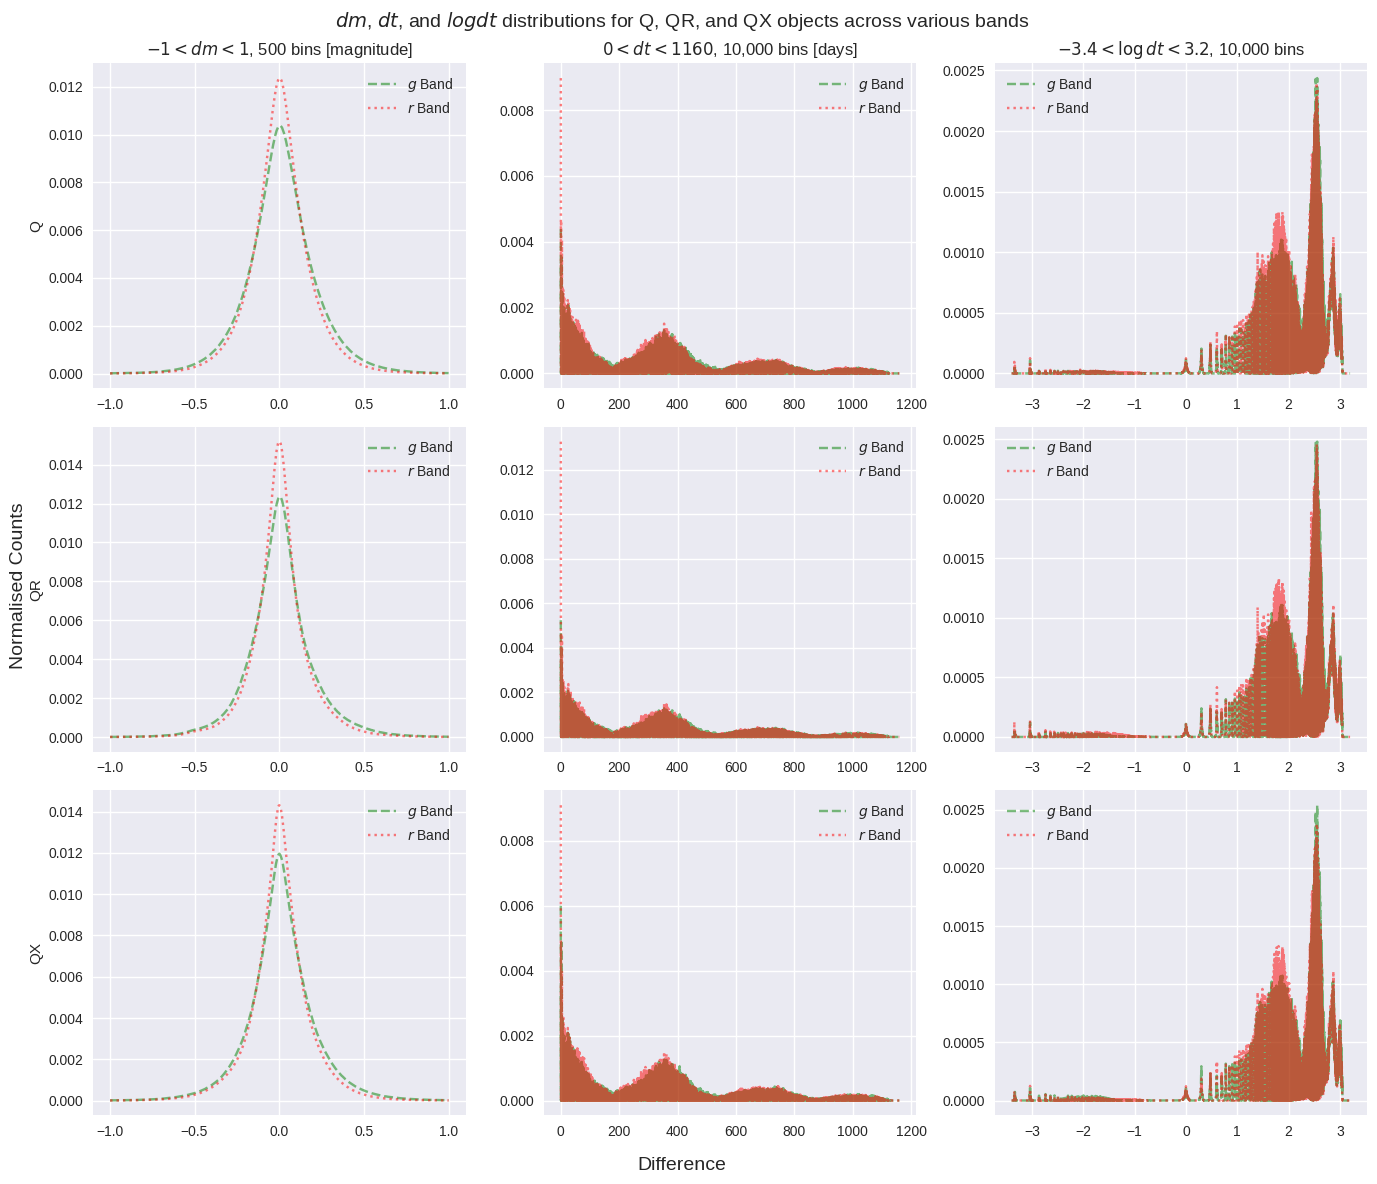

In [10]:
distribution_df = pd.read_pickle(distribution_save_path + f'QSO_distributions_dm_{dm_min}_{dm_max}_{dm_nbins}_dt_{dt_min}_{dt_max}_{dt_nbins}_logdt_{logdt_min}_{logdt_max}_{logdt_nbins}.pkl')

# dm distributions
dm_distribution_Qs = distribution_df[distribution_df['type'] == 'Q']['dm_histogram'].sum()
g_dm_distribution_Qs = distribution_df[(distribution_df['type'] == 'Q') & (distribution_df['band'] == 'g')]['dm_histogram'].sum()
r_dm_distribution_Qs = distribution_df[(distribution_df['type'] == 'Q') & (distribution_df['band'] == 'r')]['dm_histogram'].sum()

dm_distribution_QRs = distribution_df[distribution_df['type'] == 'QR']['dm_histogram'].sum()
g_dm_distribution_QRs = distribution_df[(distribution_df['type'] == 'QR') & (distribution_df['band'] == 'g')]['dm_histogram'].sum()
r_dm_distribution_QRs = distribution_df[(distribution_df['type'] == 'QR') & (distribution_df['band'] == 'r')]['dm_histogram'].sum()

dm_distribution_QXs = distribution_df[distribution_df['type'] == 'QX']['dm_histogram'].sum()
g_dm_distribution_QXs = distribution_df[(distribution_df['type'] == 'QX') & (distribution_df['band'] == 'g')]['dm_histogram'].sum()
r_dm_distribution_QXs = distribution_df[(distribution_df['type'] == 'QX') & (distribution_df['band'] == 'r')]['dm_histogram'].sum()

# dt distributions
dt_distribution_Qs = distribution_df[distribution_df['type'] == 'Q']['dt_histogram'].sum()
g_dt_distribution_Qs = distribution_df[(distribution_df['type'] == 'Q') & (distribution_df['band'] == 'g')]['dt_histogram'].sum()
r_dt_distribution_Qs = distribution_df[(distribution_df['type'] == 'Q') & (distribution_df['band'] == 'r')]['dt_histogram'].sum()

dt_distribution_QRs = distribution_df[distribution_df['type'] == 'QR']['dt_histogram'].sum()
g_dt_distribution_QRs = distribution_df[(distribution_df['type'] == 'QR') & (distribution_df['band'] == 'g')]['dt_histogram'].sum()
r_dt_distribution_QRs = distribution_df[(distribution_df['type'] == 'QR') & (distribution_df['band'] == 'r')]['dt_histogram'].sum()

dt_distribution_QXs = distribution_df[distribution_df['type'] == 'QX']['dt_histogram'].sum()
g_dt_distribution_QXs = distribution_df[(distribution_df['type'] == 'QX') & (distribution_df['band'] == 'g')]['dt_histogram'].sum()
r_dt_distribution_QXs = distribution_df[(distribution_df['type'] == 'QX') & (distribution_df['band'] == 'r')]['dt_histogram'].sum()

# logdt distributions
logdt_distribution_Qs = distribution_df[distribution_df['type'] == 'Q']['logdt_histogram'].sum()
g_logdt_distribution_Qs = distribution_df[(distribution_df['type'] == 'Q') & (distribution_df['band'] == 'g')]['logdt_histogram'].sum()
r_logdt_distribution_Qs = distribution_df[(distribution_df['type'] == 'Q') & (distribution_df['band'] == 'r')]['logdt_histogram'].sum()

logdt_distribution_QRs = distribution_df[distribution_df['type'] == 'QR']['logdt_histogram'].sum()
g_logdt_distribution_QRs = distribution_df[(distribution_df['type'] == 'QR') & (distribution_df['band'] == 'g')]['logdt_histogram'].sum()
r_logdt_distribution_QRs = distribution_df[(distribution_df['type'] == 'QR') & (distribution_df['band'] == 'r')]['logdt_histogram'].sum()

logdt_distribution_QXs = distribution_df[distribution_df['type'] == 'QX']['logdt_histogram'].sum()
g_logdt_distribution_QXs = distribution_df[(distribution_df['type'] == 'QX') & (distribution_df['band'] == 'g')]['logdt_histogram'].sum()
r_logdt_distribution_QXs = distribution_df[(distribution_df['type'] == 'QX') & (distribution_df['band'] == 'r')]['logdt_histogram'].sum()


### Plots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(14, 12))

axs[0, 0].plot(dm_bin_centres, norm(g_dm_distribution_Qs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[0, 0].plot(dm_bin_centres, norm(r_dm_distribution_Qs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')
axs[0, 0].set_ylabel('Q')
axs[0, 0].set_title(f'${dm_min} < dm < {dm_max}$, {dm_nbins:,} bins [magnitude]')


axs[1, 0].plot(dm_bin_centres, norm(g_dm_distribution_QRs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[1, 0].plot(dm_bin_centres, norm(r_dm_distribution_QRs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')
axs[1, 0].set_ylabel('QR')

axs[2, 0].plot(dm_bin_centres, norm(g_dm_distribution_QXs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[2, 0].plot(dm_bin_centres, norm(r_dm_distribution_QXs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')
axs[2, 0].set_ylabel('QX')

axs[0, 1].plot(dt_bin_centres, norm(g_dt_distribution_Qs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[0, 1].plot(dt_bin_centres, norm(r_dt_distribution_Qs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')
axs[0, 1].set_title(f'${dt_min} < dt < {dt_max}$, {dt_nbins:,} bins [days]')

axs[1, 1].plot(dt_bin_centres, norm(g_dt_distribution_QRs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[1, 1].plot(dt_bin_centres, norm(r_dt_distribution_QRs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')

axs[2, 1].plot(dt_bin_centres, norm(g_dt_distribution_QXs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[2, 1].plot(dt_bin_centres, norm(r_dt_distribution_QXs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')


axs[0, 2].plot(logdt_bin_centres, norm(g_logdt_distribution_Qs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[0, 2].plot(logdt_bin_centres, norm(r_logdt_distribution_Qs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')
axs[0, 2].set_title(f'${logdt_min} < \log dt < {logdt_max}$, {logdt_nbins:,} bins')

axs[1, 2].plot(logdt_bin_centres, norm(g_logdt_distribution_QRs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[1, 2].plot(logdt_bin_centres, norm(r_logdt_distribution_QRs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')

axs[2, 2].plot(logdt_bin_centres, norm(g_logdt_distribution_QXs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[2, 2].plot(logdt_bin_centres, norm(r_logdt_distribution_QXs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')

# axs[1].set_xlim(20, 10_000)

for ax in axs.flatten():
    ax.legend()

fig.suptitle('$dm$, $dt$, and $log dt$ distributions for Q, QR, and QX objects across various bands', size=14)
fig.supylabel('Normalised Counts', size=14)
fig.supxlabel('Difference', size=14)

plt.tight_layout()
plt.show()

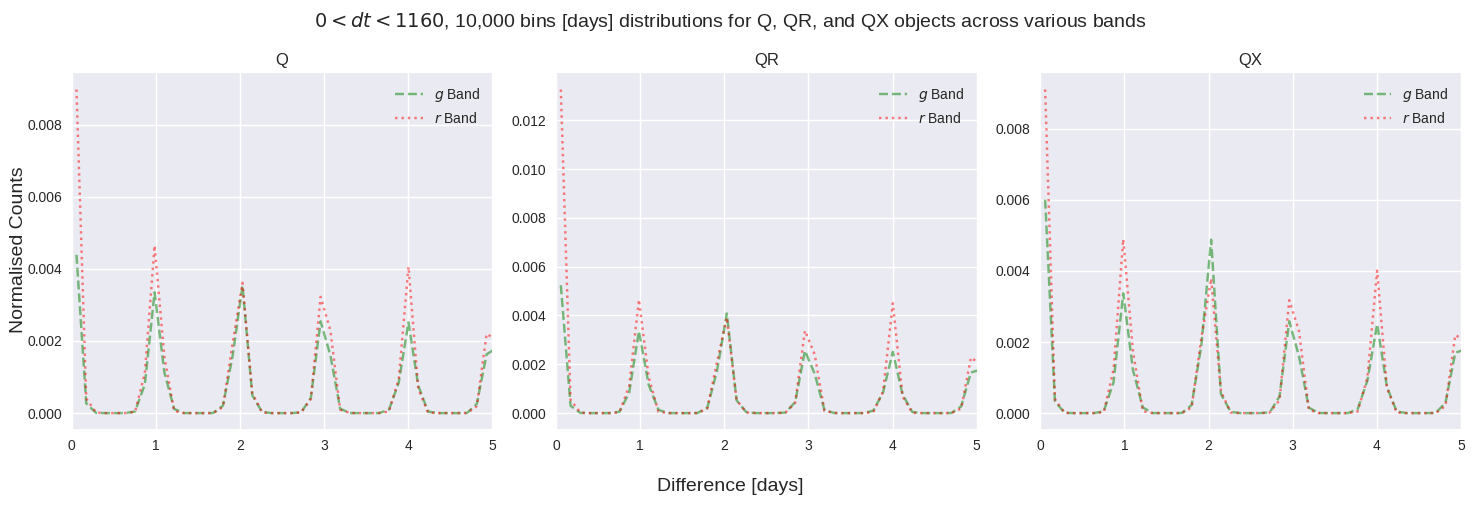

In [11]:
# distribution_df = pd.read_pickle(distribution_save_path + f'QSO_distributions_dm_{dm_min}_{dm_max}_{dm_nbins}_dt_{dt_min}_{dt_max}_{dt_nbins}_logdt_{logdt_min}_{logdt_max}_{logdt_nbins}.pkl')

# dt distributions
dt_distribution_Qs = distribution_df[distribution_df['type'] == 'Q']['dt_histogram'].sum()
g_dt_distribution_Qs = distribution_df[(distribution_df['type'] == 'Q') & (distribution_df['band'] == 'g')]['dt_histogram'].sum()
r_dt_distribution_Qs = distribution_df[(distribution_df['type'] == 'Q') & (distribution_df['band'] == 'r')]['dt_histogram'].sum()

dt_distribution_QRs = distribution_df[distribution_df['type'] == 'QR']['dt_histogram'].sum()
g_dt_distribution_QRs = distribution_df[(distribution_df['type'] == 'QR') & (distribution_df['band'] == 'g')]['dt_histogram'].sum()
r_dt_distribution_QRs = distribution_df[(distribution_df['type'] == 'QR') & (distribution_df['band'] == 'r')]['dt_histogram'].sum()

dt_distribution_QXs = distribution_df[distribution_df['type'] == 'QX']['dt_histogram'].sum()
g_dt_distribution_QXs = distribution_df[(distribution_df['type'] == 'QX') & (distribution_df['band'] == 'g')]['dt_histogram'].sum()
r_dt_distribution_QXs = distribution_df[(distribution_df['type'] == 'QX') & (distribution_df['band'] == 'r')]['dt_histogram'].sum()

### Plots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axs[0].plot(dt_bin_centres, norm(g_dt_distribution_Qs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[0].plot(dt_bin_centres, norm(r_dt_distribution_Qs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')
axs[0].set_title('Q')

axs[1].plot(dt_bin_centres, norm(g_dt_distribution_QRs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[1].plot(dt_bin_centres, norm(r_dt_distribution_QRs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')
axs[1].set_title('QR')

axs[2].plot(dt_bin_centres, norm(g_dt_distribution_QXs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[2].plot(dt_bin_centres, norm(r_dt_distribution_QXs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')
axs[2].set_title('QX')

for ax in axs:
    ax.legend()
    ax.set_xlim(0, 5)

fig.suptitle(f'${dt_min} < dt < {dt_max}$, {dt_nbins:,} bins [days] distributions for Q, QR, and QX objects across various bands', size=14)
fig.supylabel('Normalised Counts', size=14)
fig.supxlabel('Difference [days]', size=14)

plt.tight_layout()
plt.show()

### So what should our bins be?

We'll roughly divide bins to include approximately equal areas under the curves.

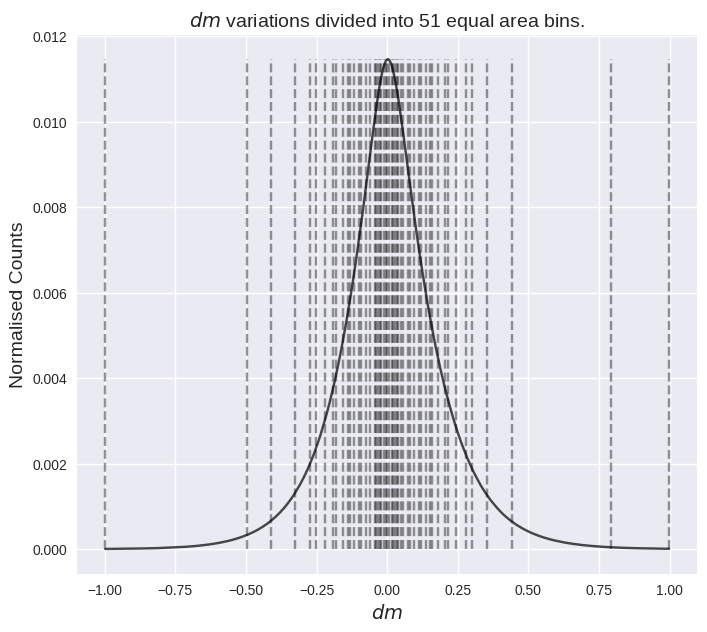

In [12]:
# distribution_df = pd.read_pickle(distribution_save_path + f'QSO_distributions_dm_{dm_min}_{dm_max}_{dm_nbins}_dt_{dt_min}_{dt_max}_{dt_nbins}_logdt_{logdt_min}_{logdt_max}_{logdt_nbins}.pkl')

# dm distributions
dm_distribution_Qs = distribution_df[distribution_df['type'] == 'Q']['dm_histogram'].sum()

### Plots
plt.figure(figsize=(8, 7))

plt.plot(dm_bin_centres, norm(dm_distribution_Qs), color='k', label='Combined Bands', alpha=0.7)

n_bins = 51
bin_edges = return_equal_bins(dm_bin_centres, norm(dm_distribution_Qs), n_bins)
plt.vlines(bin_edges, 0, norm(dm_distribution_Qs).max(), linestyles='dashed', label=f'$x = 3.1$', color='k', alpha=0.4)

plt.xlabel('$dm$', size=14)
plt.ylabel('Normalised Counts', size=14)
plt.title(f'$dm$ variations divided into {n_bins} equal area bins.', size=14)

plt.show()

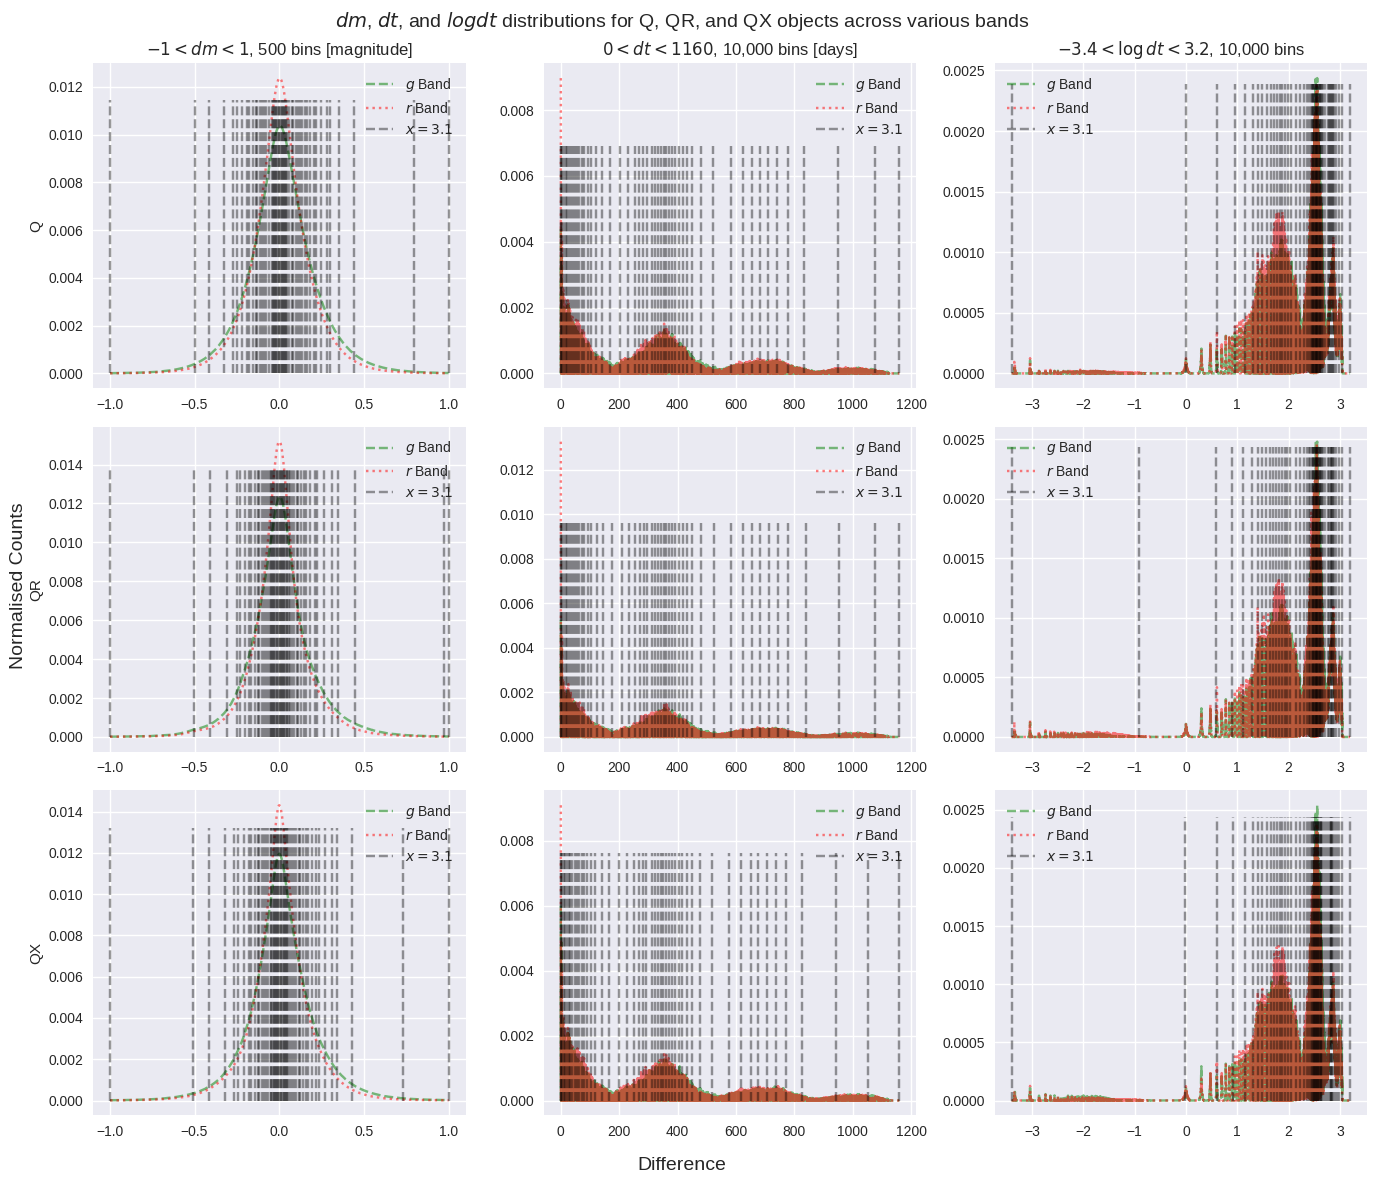

In [13]:
# distribution_df = pd.read_pickle(distribution_save_path + f'QSO_distributions_dm_{dm_min}_{dm_max}_{dm_nbins}_dt_{dt_min}_{dt_max}_{dt_nbins}_logdt_{logdt_min}_{logdt_max}_{logdt_nbins}.pkl')

# dm distributions
dm_distribution_Qs = distribution_df[distribution_df['type'] == 'Q']['dm_histogram'].sum()
g_dm_distribution_Qs = distribution_df[(distribution_df['type'] == 'Q') & (distribution_df['band'] == 'g')]['dm_histogram'].sum()
r_dm_distribution_Qs = distribution_df[(distribution_df['type'] == 'Q') & (distribution_df['band'] == 'r')]['dm_histogram'].sum()

dm_distribution_QRs = distribution_df[distribution_df['type'] == 'QR']['dm_histogram'].sum()
g_dm_distribution_QRs = distribution_df[(distribution_df['type'] == 'QR') & (distribution_df['band'] == 'g')]['dm_histogram'].sum()
r_dm_distribution_QRs = distribution_df[(distribution_df['type'] == 'QR') & (distribution_df['band'] == 'r')]['dm_histogram'].sum()

dm_distribution_QXs = distribution_df[distribution_df['type'] == 'QX']['dm_histogram'].sum()
g_dm_distribution_QXs = distribution_df[(distribution_df['type'] == 'QX') & (distribution_df['band'] == 'g')]['dm_histogram'].sum()
r_dm_distribution_QXs = distribution_df[(distribution_df['type'] == 'QX') & (distribution_df['band'] == 'r')]['dm_histogram'].sum()

# dt distributions
dt_distribution_Qs = distribution_df[distribution_df['type'] == 'Q']['dt_histogram'].sum()
g_dt_distribution_Qs = distribution_df[(distribution_df['type'] == 'Q') & (distribution_df['band'] == 'g')]['dt_histogram'].sum()
r_dt_distribution_Qs = distribution_df[(distribution_df['type'] == 'Q') & (distribution_df['band'] == 'r')]['dt_histogram'].sum()

dt_distribution_QRs = distribution_df[distribution_df['type'] == 'QR']['dt_histogram'].sum()
g_dt_distribution_QRs = distribution_df[(distribution_df['type'] == 'QR') & (distribution_df['band'] == 'g')]['dt_histogram'].sum()
r_dt_distribution_QRs = distribution_df[(distribution_df['type'] == 'QR') & (distribution_df['band'] == 'r')]['dt_histogram'].sum()

dt_distribution_QXs = distribution_df[distribution_df['type'] == 'QX']['dt_histogram'].sum()
g_dt_distribution_QXs = distribution_df[(distribution_df['type'] == 'QX') & (distribution_df['band'] == 'g')]['dt_histogram'].sum()
r_dt_distribution_QXs = distribution_df[(distribution_df['type'] == 'QX') & (distribution_df['band'] == 'r')]['dt_histogram'].sum()

# logdt distributions
logdt_distribution_Qs = distribution_df[distribution_df['type'] == 'Q']['logdt_histogram'].sum()
g_logdt_distribution_Qs = distribution_df[(distribution_df['type'] == 'Q') & (distribution_df['band'] == 'g')]['logdt_histogram'].sum()
r_logdt_distribution_Qs = distribution_df[(distribution_df['type'] == 'Q') & (distribution_df['band'] == 'r')]['logdt_histogram'].sum()

logdt_distribution_QRs = distribution_df[distribution_df['type'] == 'QR']['logdt_histogram'].sum()
g_logdt_distribution_QRs = distribution_df[(distribution_df['type'] == 'QR') & (distribution_df['band'] == 'g')]['logdt_histogram'].sum()
r_logdt_distribution_QRs = distribution_df[(distribution_df['type'] == 'QR') & (distribution_df['band'] == 'r')]['logdt_histogram'].sum()

logdt_distribution_QXs = distribution_df[distribution_df['type'] == 'QX']['logdt_histogram'].sum()
g_logdt_distribution_QXs = distribution_df[(distribution_df['type'] == 'QX') & (distribution_df['band'] == 'g')]['logdt_histogram'].sum()
r_logdt_distribution_QXs = distribution_df[(distribution_df['type'] == 'QX') & (distribution_df['band'] == 'r')]['logdt_histogram'].sum()


### Plots
n_bins = 51
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(14, 12))

axs[0, 0].plot(dm_bin_centres, norm(g_dm_distribution_Qs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[0, 0].plot(dm_bin_centres, norm(r_dm_distribution_Qs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')
bin_edges = return_equal_bins(dm_bin_centres, norm(dm_distribution_Qs), n_bins)
axs[0, 0].vlines(bin_edges, 0, norm(dm_distribution_Qs).max(), linestyles='dashed', label=f'$x = 3.1$', color='k', alpha=0.4)
axs[0, 0].set_ylabel('Q')
axs[0, 0].set_title(f'${dm_min} < dm < {dm_max}$, {dm_nbins:,} bins [magnitude]')


axs[1, 0].plot(dm_bin_centres, norm(g_dm_distribution_QRs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[1, 0].plot(dm_bin_centres, norm(r_dm_distribution_QRs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')
bin_edges = return_equal_bins(dm_bin_centres, norm(dm_distribution_QRs), n_bins)
axs[1, 0].vlines(bin_edges, 0, norm(dm_distribution_QRs).max(), linestyles='dashed', label=f'$x = 3.1$', color='k', alpha=0.4)
axs[1, 0].set_ylabel('QR')

axs[2, 0].plot(dm_bin_centres, norm(g_dm_distribution_QXs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[2, 0].plot(dm_bin_centres, norm(r_dm_distribution_QXs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')
bin_edges = return_equal_bins(dm_bin_centres, norm(dm_distribution_QXs), n_bins)
axs[2, 0].vlines(bin_edges, 0, norm(dm_distribution_QXs).max(), linestyles='dashed', label=f'$x = 3.1$', color='k', alpha=0.4)
axs[2, 0].set_ylabel('QX')

axs[0, 1].plot(dt_bin_centres, norm(g_dt_distribution_Qs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[0, 1].plot(dt_bin_centres, norm(r_dt_distribution_Qs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')
bin_edges = return_equal_bins(dt_bin_centres, norm(dt_distribution_Qs), n_bins)
axs[0, 1].vlines(bin_edges, 0, norm(dt_distribution_Qs).max(), linestyles='dashed', label=f'$x = 3.1$', color='k', alpha=0.4)
axs[0, 1].set_title(f'${dt_min} < dt < {dt_max}$, {dt_nbins:,} bins [days]')

axs[1, 1].plot(dt_bin_centres, norm(g_dt_distribution_QRs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[1, 1].plot(dt_bin_centres, norm(r_dt_distribution_QRs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')
bin_edges = return_equal_bins(dt_bin_centres, norm(dt_distribution_QRs), n_bins)
axs[1, 1].vlines(bin_edges, 0, norm(dt_distribution_QRs).max(), linestyles='dashed', label=f'$x = 3.1$', color='k', alpha=0.4)

axs[2, 1].plot(dt_bin_centres, norm(g_dt_distribution_QXs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[2, 1].plot(dt_bin_centres, norm(r_dt_distribution_QXs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')
bin_edges = return_equal_bins(dt_bin_centres, norm(dt_distribution_QXs), n_bins)
axs[2, 1].vlines(bin_edges, 0, norm(dt_distribution_QXs).max(), linestyles='dashed', label=f'$x = 3.1$', color='k', alpha=0.4)


axs[0, 2].plot(logdt_bin_centres, norm(g_logdt_distribution_Qs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[0, 2].plot(logdt_bin_centres, norm(r_logdt_distribution_Qs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')
bin_edges = return_equal_bins(logdt_bin_centres, norm(logdt_distribution_Qs), n_bins)
axs[0, 2].vlines(bin_edges, 0, norm(logdt_distribution_Qs).max(), linestyles='dashed', label=f'$x = 3.1$', color='k', alpha=0.4)
axs[0, 2].set_title(f'${logdt_min} < \log dt < {logdt_max}$, {logdt_nbins:,} bins')

axs[1, 2].plot(logdt_bin_centres, norm(g_logdt_distribution_QRs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[1, 2].plot(logdt_bin_centres, norm(r_logdt_distribution_QRs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')
bin_edges = return_equal_bins(logdt_bin_centres, norm(logdt_distribution_QRs), n_bins)
axs[1, 2].vlines(bin_edges, 0, norm(logdt_distribution_QRs).max(), linestyles='dashed', label=f'$x = 3.1$', color='k', alpha=0.4)

axs[2, 2].plot(logdt_bin_centres, norm(g_logdt_distribution_QXs), color='g', label='$g$ Band', alpha=0.5, linestyle='--')
axs[2, 2].plot(logdt_bin_centres, norm(r_logdt_distribution_QXs), color='r', label='$r$ Band', alpha=0.5, linestyle=':')
bin_edges = return_equal_bins(logdt_bin_centres, norm(logdt_distribution_QXs), n_bins)
axs[2, 2].vlines(bin_edges, 0, norm(logdt_distribution_QXs).max(), linestyles='dashed', label=f'$x = 3.1$', color='k', alpha=0.4)

# axs[1].set_xlim(20, 10_000)

for ax in axs.flatten():
    ax.legend()

fig.suptitle('$dm$, $dt$, and $log dt$ distributions for Q, QR, and QX objects across various bands', size=14)
fig.supylabel('Normalised Counts', size=14)
fig.supxlabel('Difference', size=14)

plt.tight_layout()
plt.show()

In [14]:
dm_distribution_QSOs = distribution_df['dm_histogram'].sum()
dt_distribution_QSOs = distribution_df['dt_histogram'].sum()
logdt_distribution_QSOs = distribution_df['logdt_histogram'].sum()

np.save(distribution_save_path + 'equivalent_bins_50x50_QSOs/QSO_dm_bins.npy', return_equal_bins(dm_bin_centres, norm(dm_distribution_QSOs), n_bins))
np.save(distribution_save_path + 'equivalent_bins_50x50_QSOs/QSO_dt_bins.npy', return_equal_bins(dt_bin_centres, norm(dt_distribution_QSOs), n_bins))
np.save(distribution_save_path + 'equivalent_bins_50x50_QSOs/QSO_logdt_bins.npy', return_equal_bins(logdt_bin_centres, norm(logdt_distribution_QSOs), n_bins))

np.save(distribution_save_path + 'equivalent_bins_50x50_QSOs/Q_dm_bins.npy', return_equal_bins(dm_bin_centres, norm(dm_distribution_Qs), n_bins))
np.save(distribution_save_path + 'equivalent_bins_50x50_QSOs/Q_dt_bins.npy', return_equal_bins(dt_bin_centres, norm(dt_distribution_Qs), n_bins))
np.save(distribution_save_path + 'equivalent_bins_50x50_QSOs/Q_logdt_bins.npy', return_equal_bins(logdt_bin_centres, norm(logdt_distribution_Qs), n_bins))

np.save(distribution_save_path + 'equivalent_bins_50x50_QSOs/QR_dm_bins.npy', return_equal_bins(dm_bin_centres, norm(dm_distribution_QRs), n_bins))
np.save(distribution_save_path + 'equivalent_bins_50x50_QSOs/QR_dt_bins.npy', return_equal_bins(dt_bin_centres, norm(dt_distribution_QRs), n_bins))
np.save(distribution_save_path + 'equivalent_bins_50x50_QSOs/QR_logdt_bins.npy', return_equal_bins(logdt_bin_centres, norm(logdt_distribution_QRs), n_bins))

np.save(distribution_save_path + 'equivalent_bins_50x50_QSOs/QX_dm_bins.npy', return_equal_bins(dm_bin_centres, norm(dm_distribution_QXs), n_bins))
np.save(distribution_save_path + 'equivalent_bins_50x50_QSOs/QX_dt_bins.npy', return_equal_bins(dt_bin_centres, norm(dt_distribution_QXs), n_bins))
np.save(distribution_save_path + 'equivalent_bins_50x50_QSOs/QX_logdt_bins.npy', return_equal_bins(logdt_bin_centres, norm(logdt_distribution_QXs), n_bins))